In [1]:
## Use the setup.py file to output directories. 
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/')

from setup import *
toolsdir = tools_dir()
repodir = repo_dir()
chainsdir = chains_dir()
datadir = data_dir()
plotdir = plots_dir()

sys.path.append(toolsdir)
sys.path.append(repodir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.cm as cm
#from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import f_regression
from statsmodels.stats.anova import anova_lm
from statsmodels.compat import lzip
#sns.set()
#pd.set_option('display.notebook_repr_html', True)
#pd.set_option('display.precision', 2)
#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 10, 10
from scipy.stats import norm
from scipy import stats

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
## KLLR setup
import sys
sys.path.append('/global/u1/z/zzhang13')

from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *
from kllr.kllr.calc_cov_KLLR import *

kllr_nbins= 20
kernel_type = 'gaussian'
kernel_width = 0.1

In [5]:
from data_bins import r_cent_lin_norm, r_cent_log_norm
from data_bins import mass_bins, mass_bin_cent
from data_bins import a_bins

## Testing -- Compute Sigma_R from colossus

In [127]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck13')
k = 10**np.linspace(-2.0, 3.0, 100)
R = 10**np.linspace(-1, 1, 100)


P = cosmo.matterPowerSpectrum(k, z = 1.0)
variance = cosmo.sigma(R, z = 0.0)

Deleted outdated persistence file, no further action needed.


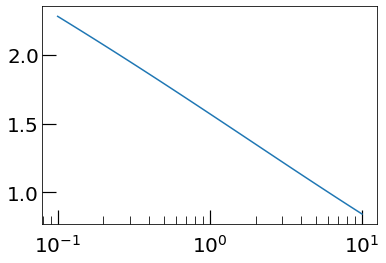

In [128]:
plt.plot(R, np.sqrt(variance))
plt.xscale('log')

In [130]:
## Critical density of the universe
rho_m = cosmo.rho_m(0.0)

In [131]:
Dp = 200 # Mpc/h
sigma_m = 1e9*Dp*rho_c #Convert from kpc^3 to Mpc^3 and multiply by projection depth
print('{:.2g}'.format(sigma_m))

1.7e+13


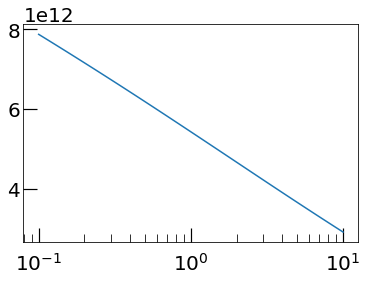

In [133]:
plt.plot(R, 0.2*np.sqrt(variance)*sigma_c)
plt.xscale('log')

## Bootstrap error for DeltaSigma
* For z = 0, use number of clusters as proxy for particle resolution. Should be the same thing. 

In [134]:
with open(datadir + 'MDPL2_DS_R200c_SAGE_Ngal_allM_allz.p', 'rb') as handle:
    matched_halo_df = pickle.load(handle)
matched_halo_df.columns

Index(['id', 'Xoff', 'scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x',
       'y', 'z', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|',
       'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

In [135]:
def calc_bootstrap_cov_DS_radii(y, nBootstrap=50):     
    output_Data = {}
    
    cov_bins = len(y[0,:])
    covariance = np.zeros((cov_bins, cov_bins, nBootstrap))
    correlation = np.zeros((cov_bins, cov_bins, nBootstrap))
    
    for i in range(cov_bins):
        y_i = y[:,i]
        for j in range(cov_bins):
            y_j = y[:,j]
    
            for k in range(nBootstrap):
                #First "bootstrap" is always using unsampled data
                if k == 0:
                    rand_ind = np.ones(y_i.size).astype(bool)
                else:
                    rand_ind = np.random.randint(0, y_i.size, y_i.size)

                # Store the shuffled variables so you don't have to
                # compute the shuffle multiple times
                y_i_rand = y_i[rand_ind]
                y_j_rand = y_j[rand_ind]

                #Compute the covariance
                cov = np.cov(y_i_rand, y_j_rand)
                covariance[i,j,k] = cov[1, 0]     
                correlation[i,j,k] = cov[1, 0]/np.sqrt(cov[0,0] * cov[1,1])    
    
    output_Data['covariance'] = covariance
    output_Data['correlation'] = correlation
    return output_Data

In [156]:
mass_min = 1e14; mass_max = 2e15; cur_a_bin = 1
mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
cur_df = matched_halo_df[mask]

In [157]:
np.shape(np.vstack(cur_df['delta_sigma']))

(1500, 20)

In [158]:
with open('DS_dz200_n20.pkl','rb') as handle:
    DS_dz200_n20 = pickle.load(handle)

In [159]:
print(np.mean(cur_df['R200c']))

1.0155544558468013


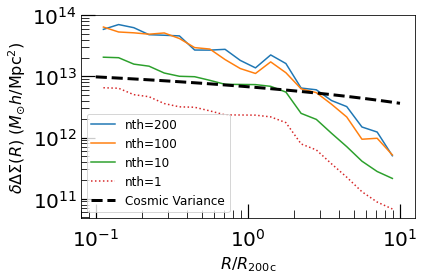

In [164]:
mean = np.mean(np.vstack(cur_df['delta_sigma']),axis=0)
n_sample = {'nth=200':25,'nth=100':50, 'nth=10':500}
fontsize=16
plt.figure(figsize=(6,4), tight_layout=True)

for k,v in n_sample.items():

    output = calc_bootstrap_cov_DS_radii(np.vstack(cur_df['delta_sigma'])[:v,:], nBootstrap=100)
    covariance = output['covariance']
    correlation = output['correlation']
    err_bin = np.std(covariance,axis=2)
    mean_bin = np.mean(covariance,axis=2)
    rel_err = err_bin/mean_bin
    err_diag = mean*[rel_err[i,i] for i in range(len(err_bin))]
    plt.plot(r_cent_lin_norm, err_diag, label=k)
        
plt.plot(r_cent_lin_norm, err_diag/np.sqrt(10), label='nth=1', linestyle='dotted')
plt.plot(R, 0.25*np.sqrt(variance)*sigma_m, label='Cosmic Variance', linestyle='dashed', color='black', linewidth='3')
plt.xlabel(r'$R/R_{\rm 200c}$', fontsize=fontsize)
plt.ylabel(r'$\delta\Delta\Sigma(R)~(M_{\odot}h/\rm Mpc^{2})$', fontsize=fontsize)
plt.xscale('log'); plt.yscale('log')
plt.legend(fontsize=12)
plt.savefig(plotdir+'ptcl_resolution_error.pdf')
plt.show()